In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import losses
import matplotlib.pyplot as plt
import os
import tensorflow as tf 


In [2]:
CUR_DIR = os.getcwd()
TRAIN_DIR = os.path.join(CUR_DIR, "data", "train")
TEST_DIR = os.path.join(CUR_DIR, "data", "test")
BATCH_SIZE = 32

In [3]:
#creates a labelled tf.data.Dataset
raw_train_dataset = tf.keras.preprocessing.text_dataset_from_directory(TRAIN_DIR, batch_size=BATCH_SIZE,)
raw_test_dataset = tf.keras.preprocessing.text_dataset_from_directory(TEST_DIR, batch_size=BATCH_SIZE)


Found 1306 files belonging to 2 classes.
Found 158 files belonging to 2 classes.


In [4]:
#1024 words will be in the table mapping words to vectors
max_features = 1024
#output will be tensors of shape [batch_size, sequence_length=8], optimizing for average discord messages of ~8 words
sequence_length = 8

#note TextVectorization automatically standardizes the samples by lowercasing and stripping punctuation
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [5]:
#removes the labels from the dataset
train_text = raw_train_dataset.map(lambda x, y: x)

#fits the state of the vectorize_layer to the dataset
vectorize_layer.adapt(train_text)

In [6]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [7]:
#applies the vectorize_layer to the dataset
train_dataset = raw_train_dataset.map(vectorize_text)
test_dataset = raw_test_dataset.map(vectorize_text)

In [8]:
#performance tweaking data loading for training
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
#each embedding vector will be of 131,072 dimension
embedding_dim = 131072
model = tf.keras.Sequential([

  #maps words(by token) to embedding vector
  layers.Embedding(max_features + 1, embedding_dim),

  #randomly sets input units to 0 with frequency of 0.2 to prevent overfitting
  layers.Dropout(0.2),
  
  #returns a singular ouput vector for each example by averaging over the dimensions, dealing with different length inputs
  layers.GlobalAveragePooling1D(),

  #randomly sets input units to 0 with frequency of 0.2 to prevent overfitting
  layers.Dropout(0.2),

  #dense layer, 4 units
  layers.Dense(4),

  #dense layer, dimension of output = 1
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 131072)      134348800 
_________________________________________________________________
dropout (Dropout)            (None, None, 131072)      0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 131072)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 4)                 524292    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 134,873,097
Trainable params: 134,873,097
Non-trainable params: 0
__________________________________________

In [10]:
 #note from_logits=True, so softmax function is handled inside the loss
 model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [15]:
epochs = 12
history = model.fit(
    train_ds,
    epochs=epochs)

Epoch 1/12
41/41 [==============================] - 43s 1s/step - loss: 0.0219 - binary_accuracy: 0.9977
Epoch 2/12
41/41 [==============================] - 42s 1s/step - loss: 0.0221 - binary_accuracy: 0.9985
Epoch 3/12
41/41 [==============================] - 41s 1s/step - loss: 0.0185 - binary_accuracy: 0.9992
Epoch 4/12
41/41 [==============================] - 42s 1s/step - loss: 0.0156 - binary_accuracy: 0.9992
Epoch 5/12
41/41 [==============================] - 45s 1s/step - loss: 0.0148 - binary_accuracy: 0.9992
Epoch 6/12
41/41 [==============================] - 44s 1s/step - loss: 0.0147 - binary_accuracy: 0.9992
Epoch 7/12
41/41 [==============================] - 45s 1s/step - loss: 0.0143 - binary_accuracy: 0.9992
Epoch 8/12
41/41 [==============================] - 45s 1s/step - loss: 0.0143 - binary_accuracy: 0.9992
Epoch 9/12
41/41 [==============================] - 44s 1s/step - loss: 0.0143 - binary_accuracy: 0.9992
Epoch 10/12
41/41 [==============================] - 42

In [16]:
loss, accuracy = model.evaluate(test_dataset)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 0s 29ms/step - loss: 1.1041 - binary_accuracy: 0.8101
Loss:  1.1041321754455566
Accuracy:  0.8101266026496887


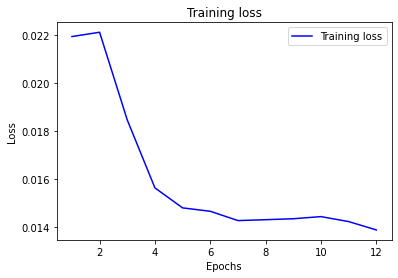

In [18]:
history_dict = history.history
history_dict.keys()
acc = history_dict['binary_accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
#builds a deployable model with vectorize_layer inside, so it can take a string as an input
model_built_in_text_vectorizer = tf.keras.Sequential([
  vectorize_layer,
  model,
  #sigmoid because it is a probability
  layers.Activation('sigmoid')
])
model_built_in_text_vectorizer.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

In [24]:
#saves the model that can be implemented (with a text-vectorizing layer)
model_built_in_text_vectorizer.save("accurate_model_0")